# Lets start building the OCR from What we've learned so far

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Import Dependencies

In [2]:
import time
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from keras.datasets import mnist

### class LayerDense

In [3]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)


### class ActivationReLU

In [4]:
class ActivationReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

### class ActivationSoftMax

In [5]:
class ActivationSoftMax:
    def forward(self, inputs):
        self.exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.probabilities = self.exp_values / np.sum(self.exp_values, axis=1, keepdims=True)
        self.output = self.probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

### class Loss

In [6]:
class Loss:
    def calculate(self, output, y):
        self.sample_losses = self.forward(output, y)
        self.data_loss = np.mean(self.sample_losses)
        return self.data_loss

### class LossCategoricalCrossEntropy

In [7]:
class LossCategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if y_true.ndim == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif y_true.ndim == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if y_true.ndim == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

### class Optimizer_Adam

In [8]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

### Define layer, activation instances

In [9]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = Y_train
y_test = Y_test

input_layer = Layer_Dense(784, 128)
activation_input = ActivationReLU()

hidden_layer1 = Layer_Dense(128, 64)
activation1 = ActivationReLU()

hidden_layer2 = Layer_Dense(64, 64)
activation2 = ActivationReLU()

output_layer = Layer_Dense(64, 10)
activation_output = ActivationSoftMax()

loss_function = LossCategoricalCrossEntropy()
optimizer = Optimizer_Adam()

losses = []
accuracies = []
epochs = 60

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Training Loop

In [10]:
for epoch in range(epochs):
    input_layer.forward(X_train)
    activation_input.forward(input_layer.output)

    hidden_layer1.forward(activation_input.output)
    activation1.forward(hidden_layer1.output)

    hidden_layer2.forward(activation1.output)
    activation2.forward(hidden_layer2.output)

    output_layer.forward(activation2.output)
    activation_output.forward(output_layer.output)

    loss = loss_function.calculate(activation_output.output, y_train)
    losses.append(loss)

    predictions = np.argmax(activation_output.output, axis=1)
    accuracy = np.mean(predictions == y_train)
    accuracies.append(accuracy)

    loss_function.backward(activation_output.output, y_train)
    activation_output.backward(loss_function.dinputs)
    output_layer.backward(activation_output.dinputs)

    activation2.backward(output_layer.dinputs)
    hidden_layer2.backward(activation2.dinputs)

    activation1.backward(hidden_layer2.dinputs)
    hidden_layer1.backward(activation1.dinputs)

    activation_input.backward(hidden_layer1.dinputs)
    input_layer.backward(activation_input.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(input_layer)
    optimizer.update_params(hidden_layer1)
    optimizer.update_params(hidden_layer2)
    optimizer.update_params(output_layer)
    optimizer.post_update_params()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.3f} Accuracy: {accuracy:.3f}")

Epoch: 0, Loss: 2.348 Accuracy: 0.100
Epoch: 10, Loss: 1.837 Accuracy: 0.515
Epoch: 20, Loss: 1.066 Accuracy: 0.758
Epoch: 30, Loss: 0.576 Accuracy: 0.838
Epoch: 40, Loss: 0.403 Accuracy: 0.884
Epoch: 50, Loss: 0.326 Accuracy: 0.904


Saving Model and Visualising Accuracy over Epochs

Model saved successfully.


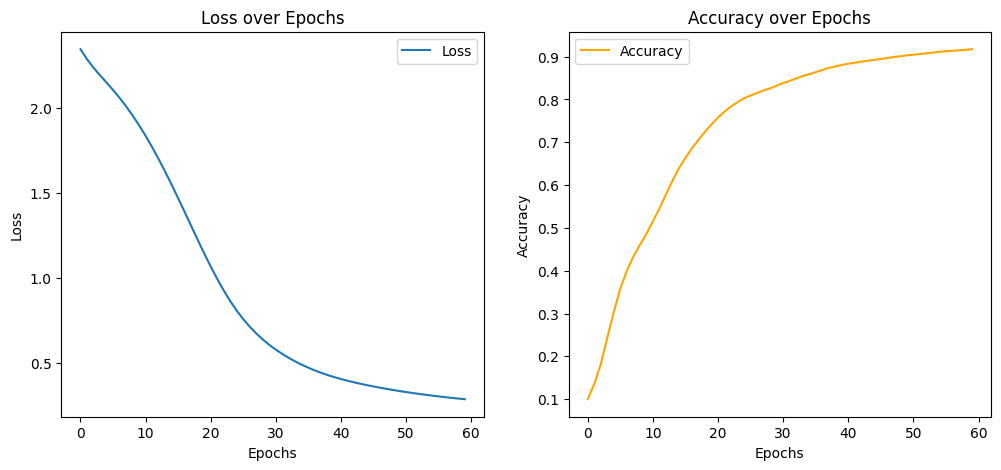

In [11]:
model_parameters = {
    "input_layer_weights": input_layer.weights,
    "input_layer_biases": input_layer.biases,
    "hidden_layer1_weights": hidden_layer1.weights,
    "hidden_layer1_biases": hidden_layer1.biases,
    "hidden_layer2_weights": hidden_layer2.weights,
    "hidden_layer2_biases": hidden_layer2.biases,
    "output_layer_weights": output_layer.weights,
    "output_layer_biases": output_layer.biases,
}

with open("OCR_Model_128,64,64,10.pkl", "wb") as f:
    pickle.dump(model_parameters, f)

print("Model saved successfully.")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), accuracies, label="Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()

# Testing the Saved Model

### Loading the model

In [12]:
with open('OCR_Model_128,64,64,10.pkl', 'rb') as f:
    model_parameters = pickle.load(f)

### Defining Classes without backward propogation and accepting given parameters

In [13]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weights, biases):
        self.weights = weights
        self.biases = biases

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

### Defining Activation ReLU function

In [14]:
class ActivationReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

### Defining Activation SoftMax Function

In [15]:
class ActivationSoftMax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities


### Prepearing Dataset

In [16]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_test = X_test / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)

### Creating Instances

In [17]:
input_layer = Layer_Dense(784, 128, model_parameters["input_layer_weights"], model_parameters["input_layer_biases"])
activation_input = ActivationReLU()

hidden_layer1 = Layer_Dense(128, 64, model_parameters["hidden_layer1_weights"], model_parameters["hidden_layer1_biases"])
activation1 = ActivationReLU()

hidden_layer2 = Layer_Dense(64, 64, model_parameters["hidden_layer2_weights"], model_parameters["hidden_layer2_biases"])
activation2 = ActivationReLU()

output_layer = Layer_Dense(64, 10, model_parameters["output_layer_weights"], model_parameters["output_layer_biases"])
activation_output = ActivationSoftMax()

### Defining forward propogation function

In [18]:
def forward_pass(X):
    input_layer.forward(X)
    activation_input.forward(input_layer.output)

    hidden_layer1.forward(activation_input.output)
    activation1.forward(hidden_layer1.output)

    hidden_layer2.forward(activation1.output)
    activation2.forward(hidden_layer2.output)

    output_layer.forward(activation2.output)
    activation_output.forward(output_layer.output)

    return activation_output.output

### Visualising the predictions made

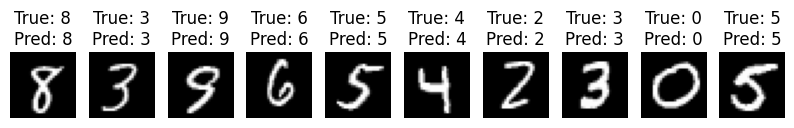

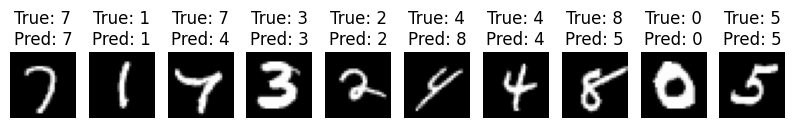

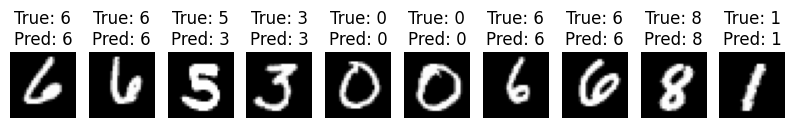

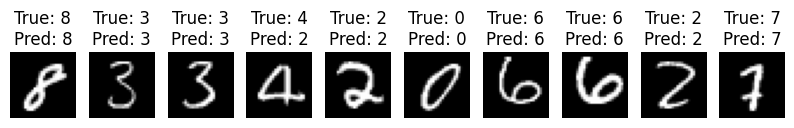

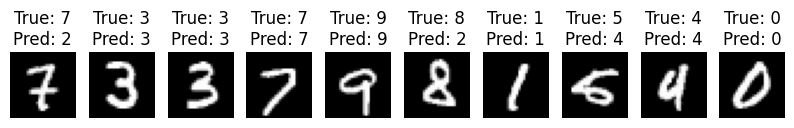

In [19]:
def visualize_predictions(X, y_true, y_pred, num_samples=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
        plt.axis('off')
    plt.show()

for _ in range(5):
    indices = np.random.choice(X_test.shape[0], 10, replace=False)
    X_sample = X_test[indices]
    y_sample = Y_test[indices]

    predictions = np.argmax(forward_pass(X_sample), axis=1)

    visualize_predictions(X_sample, y_sample, predictions, num_samples=10)